In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
from pathlib import Path
import pandas as pd

In [3]:
#path = Path('/home/ubuntu/data/autopsy/milestone/no_preprocessing')

path = Path('/home/ubuntu/data/autopsy/2014_2018/no_preprocessing/reports/k-fold-suicide-homicide')


In [4]:
df = pd.read_csv(path/'data_suicide_homicide_k_1.csv')
df.head()

,label,text,is_valid
0,Homicide,\n.MICRO.\nHEART: acute hemorrhages in the epi...,False
1,Suicide,\n.MICRO.\nNONE\n.LOCATIONNeck\n.INJURYHanging...,False
2,Homicide,\n.MICRO.\nLIVER: Moderate macrovesicular stea...,False
3,Homicide,\n.MICRO.\nHeart:\nNo significant histopatholo...,False
4,Homicide,\n.MICRO.\nNONE\n.LOCATIONTrunk\n.INJURYFirear...,False


In [5]:
df['text'][1]

'\n.MICRO.\nNONE\n.LOCATIONNeck\n.INJURYHanging.\n.INJURYDESC.\nPartially encircling the neck is a 0.75 cm brown abraded ligature furrow which anteriorly passes over the thyroid cartilage and cants upwards and backwards toward the nape of the neck lying 6.0 cm below the right ear and 3.0 cm below the left ear. No other neck trauma is present. Accompanying the body is a green electrical cord ligature which correlates with the ligature furrow of the neck. \n\n.LOCATIONHead\n.INJURYBlunt injury.\n.INJURYDESC.\nOn the left anterior forehead is a 1.0 cm linear red abrasion,.'

In [6]:
bs=32

In [7]:
valid_df =  df.loc[df['is_valid']==True]

In [8]:
train_df = df.loc[df['is_valid']==False]

In [9]:
data_lm = TextLMDataBunch.from_df(path, train_df=train_df, valid_df=valid_df, classes=['Suicide','Homicide'],bs=bs)

In [10]:
data_lm.show_batch()

idx,text
0,"no significant histopathologic diagnosis \n \n xxup esophagus : intact squamous mucosa with submucosal and intramuscular acute hemorrhages \n \n xxup thyroid : acute hemorrhage of the soft tissue adjacent to the thyroid gland , otherwise no significant histopathologic diagnosis \n .locationhead \n .injuryblunt injury . \n xxup .injurydesc . \n a 3 x 1.5 cm , irregular laceration is on the left frontal"
1,"a 1.5 x 0.3 cm abrasion is located 0.5 cm inferior to the 4 to 8 o'clock position of the wound . xxmaj soot , unburned gunpowder particles and gunpowder stippling are not visible on the skin surrounding the wound . \n \n xxmaj path : \n \n xxmaj the bullet sequentially perforated the left lower eyelid , left globe , left orbital floor , soft palate ,"
2,".locationhead \n .injuryfirearm injury . \n xxup .injurydesc . \n xxmaj the decedent has a xxunk and severely black right eye . xxbos \n xxup .micro . \n xxmaj heart : no significant histopathology \n \n xxmaj lungs : xxmaj interstitial anthracosis , scattered intra - alveolar macrophages , and mild pulmonary edema , characterized by areas of pink fluid within alveolar spaces ."
3,"right of midline , is a 2.9 cm long stab wound oriented vertically with an irregular jagged edge on the inferior wound margin that is 0.3 cm wide and a sharp edge on the superior wound margin . xxmaj the wound demonstrates evidence of medical intervention ( sutures ) . \n \n xxmaj path : \n \n xxmaj the hemorrhagic wound track perforates the skin and subcutaneous tissues"
4,"right zygomatic arch , the maxilla , the xxunk skull , the brain , and the left parieto - occipital skull and scalp . \n \n xxmaj associated injuries include fragmentation of the mandible , maxilla , basilar and calvarial skull ; lacerations of the scalp ; and partial evisceration of the brain . \n \n xxmaj exit : \n \n xxmaj on the left parieto -"


In [11]:
learn = language_model_learner(data_lm, arch=AWD_LSTM)

In [12]:
learn.freeze()

In [13]:
#do some gradual unfreezing, so we don't lose the pretrained info
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,2.399516,2.009181,0.559087,00:36
2,2.263067,1.885870,0.576708,00:36


In [14]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,2.009473,1.718549,0.601693,00:37


In [15]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,1.830191,1.637051,0.616850,00:39


In [16]:
learn.unfreeze()
learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,1.779218,1.611753,0.621225,00:42
2,1.639119,1.567519,0.629536,00:42
3,1.550906,1.515560,0.639840,00:42
4,1.524521,1.471843,0.649679,00:42
5,1.452381,1.438157,0.658117,00:42
6,1.430062,1.420291,0.662272,00:42
7,1.391525,1.413563,0.663881,00:42
8,1.362149,1.412710,0.663992,00:42


In [17]:
learn.save_encoder('fine_tuned_enc_no_pretrain')

In [18]:
data_clas = TextClasDataBunch.from_df(path, train_df=train_df, valid_df=valid_df, vocab=data_lm.train_ds.vocab, bs=bs, classes=['Suicide','Homicide'])

In [19]:
data_clas.show_batch()

text,target
"xxbos \n xxup .micro . \n xxup heart : xxmaj myocyte hypertrophy , interstitial fibrosis \n \n xxup lungs : xxmaj peripherally dilated alveolar spaces with septal clubbing alternating with areas of atelectasis ; mild deposition of black pigment around bronchioles and pleura \n \n xxup kidneys : xxmaj frequent , globally sclerotic glomeruli ; patchy interstitial fibrosis ; patchy interstitial lymphocytic inflammation \n \n",Homicide
"xxbos \n xxup .micro . \n xxmaj the heart has no significant inflammation or fibrosis . xxmaj the cardiac myocytes are unremarkable . xxmaj the myocardial vessels are patent without significant medial hypertrophy or thrombosis . \n \n xxmaj the lungs have normal alveolar architecture with atelectatic changes . xxmaj the interstitium adjacent to the bronchi and bronchioles demonstrates rare , mild , chronic inflammation . xxmaj",Homicide
"xxbos \n xxup .micro . \n xxup heart : xxmaj frequent myofibers are enlarged with ' box - xxunk nuclei . \n \n xxup kidneys : xxmaj rare , globally sclerotic glomeruli ; occasional area of predominantly lymphocytic , interstitial inflammation \n \n xxup liver : xxmaj mild to moderate , predominantly macrovesicular steatosis and mild to moderate , portal and lobular , chronic , active",Homicide
"xxbos \n xxup .micro . \n xxup brain : xxmaj scattered small ( petechial ) intraparenchymal and perivascular hemorrhages \n \n xxup heart : xxmaj no significant histopathologic findings \n \n xxup lungs : xxmaj blood in the bronchioles \n \n xxup kidneys : xxmaj no significant histopathologic findings \n \n xxup liver : xxmaj mild , predominantly macrovesicular steatosis \n \n \n",Homicide
"xxbos \n xxup .micro . \n xxup none \n .locationhead \n .injuryfirearm injury . \n xxup .injurydesc . \n xxup penetrating xxup gunshot xxup wound xxup of xxup head ( a ) \n \n xxup entrance : xxmaj on the left side of the scalp , centered 4 centimeters below the top of the head and 6 centimeters left of the anterior midline",Homicide


In [20]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc_no_pretrain')
learn.freeze()

In [21]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.516569,0.864163,0.436782,00:36


In [22]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.498367,0.457088,0.779967,00:40


In [23]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.412711,0.372545,0.834154,00:57


In [24]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(3e-4,3e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.386591,0.382327,0.827586,01:08
2,0.392022,0.342439,0.844007,01:04
3,0.388871,0.332793,0.858785,01:01
4,0.389469,0.280527,0.875205,01:02
5,0.362831,0.320748,0.848933,01:01
6,0.352178,0.263486,0.875205,01:08
7,0.284891,0.218157,0.934319,01:06
8,0.279019,0.220293,0.919540,01:01
9,0.234828,0.212094,0.919540,01:07
10,0.292874,0.221659,0.919540,00:57


In [25]:
from fastai.vision import *

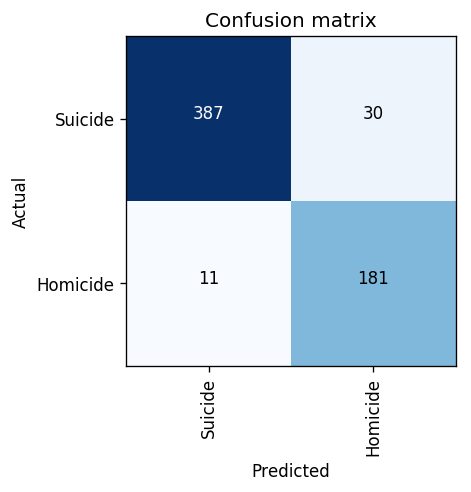

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4), dpi=120)

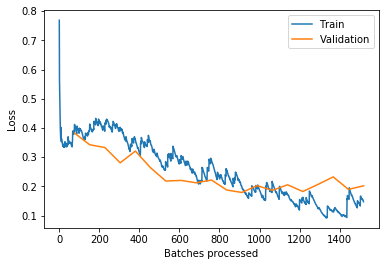

In [27]:
learn.recorder.plot_losses()

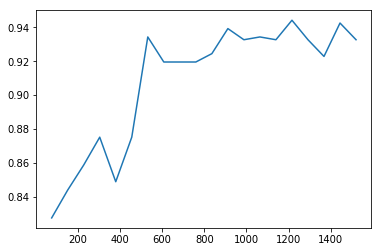

In [28]:
learn.recorder.plot_metrics()

In [29]:
def intrinsic_attention_modified_old(self, text:str, class_id:int=None):
        ids = self.data.one_item(text)[0]
        emb = self.model[0].module.encoder(ids).detach().requires_grad_(True)
        self.model.train()
        self.model.zero_grad()
        self.model.reset()
        lstm_output = self.model[0].module(emb, from_embeddings=True)
        self.model.eval()
        self.model.zero_grad()
        self.model.reset()
        cl = self.model[1](lstm_output)[0].softmax(dim=-1)
        if class_id is None: class_id = cl.argmax()
        cl[0][class_id].backward()
        attn = emb.grad.squeeze().abs().sum(dim=-1)
        attn /= attn.max()
        tokens = self.data.single_ds.reconstruct(ids[0])
        return tokens, attn
    
def intrinsic_attention_modified(self, text:str, class_id:int=None):
        """Calculate the intrinsic attention of the input w.r.t to an output `class_id`, or the classification given by the model if `None`.
        For reference, see the Sequential Jacobian session at https://www.cs.toronto.edu/~graves/preprint.pdf
        """
        self.model.train()
        eval_dropouts(self.model)
        self.model.zero_grad()
        self.model.reset()
        ids = self.data.one_item(text)[0]
        emb = self.model[0].module.encoder(ids).detach().requires_grad_(True)                
        lstm_output = self.model[0].module(emb, from_embeddings=True)
        self.model.eval()
        cl = self.model[1](lstm_output)[0].softmax(dim=-1)
        if class_id is None: class_id = cl.argmax()
        cl[0][class_id].backward()
        attn = emb.grad.squeeze().abs().sum(dim=-1)
        attn /= attn.max() 
        tokens = self.data.single_ds.reconstruct(ids[0])
        return tokens, attn

def eval_dropouts(mod):
        module_name =  mod.__class__.__name__
        if 'Dropout' in module_name or 'BatchNorm' in module_name: mod.training = False
        for module in mod.children(): eval_dropouts(module)

TextClassificationInterpretation.intrinsic_attention = intrinsic_attention_modified
ci = TextClassificationInterpretation.from_learner(learn)

In [30]:
import matplotlib.cm as cm

In [31]:
def interpret_result(row_index):
    example = df['text'][row_index]
    label = df['label'][row_index]
    print('True Label:',label)
    
    prediction_class = learn.predict(example)[0]
    prediction_probs = learn.predict(example)[2]
    
    print('\nPred Label:',prediction_class)
    print('\nClass Probabilities:',prediction_probs)
    
    print('\n***Raw Text***')
    print(example)
    
    print('\n***Intrinsic Attention***')
    
    ci.show_intrinsic_attention(example,  cmap=cm.Reds)
    
    prediction_class = learn.predict(example)[0]
    prediction_probs = learn.predict(example)[2]
    
    
    

In [32]:
interpret_result(3016)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([9.9953e-01, 4.6600e-04])

***Raw Text***

.MICRO.
NONE
.LOCATIONNeck
.INJURYHanging.
.INJURYDESC.
Ligature furrow noted encircling the neck, with upward canting to the back of the head.  Knots of the ligature used, was positioned to the back and upwards of decedent's neck.

***Intrinsic Attention***


In [33]:
interpret_result(3025)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([0.9455, 0.0545])

***Raw Text***

.MICRO.
NONE
.LOCATIONHead
.INJURYFirearm injury.
.INJURYDESC.
GUNSHOT WOUND OF HEAD, CONTACT RANGE:

Entrance:

On the right temple, 12.5 cm right of anterior midline and 8 cm below the top of the head, is an entrance gunshot wound consisting of a 1.4 x 1.4 cm round defect with 0.2 cm wide circumferential, marginal abrasion and 0.5 cm radiating laceration. Soot, unburned gunpowder particles and gunpowder stippling are not visible on the skin surrounding the wound.

Path:

The hemorrhagic wound track sequentially perforates the scalp, right temporal bone and dura mater, brain, left temporal dura mater and bone, and scalp.

Associated injuries include a laceration of the lower lip.

Exit:

On the left temple, 11 cm left of anterior midline and 7.5 cm below the top of the head is an exit gunshot wound consisting of a 2 x 1 cm stellate laceration without marginal abrasion.

Recovery: N

In [34]:
interpret_result(3026)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([0.9888, 0.0112])

***Raw Text***

.MICRO.
Heart: Cardiomyocyte hypertrophy (box-car nuclei and occasional binucleation of enlarged muscle fibers) with focal interstitial scarring.

LAD Coronary:  Calcific atherosclerosis with compression of the lumen.

Lungs: Focal hemosiderin-laden alveolar macrophages, early emphysematous changes. 

Liver: 20% macrosteatosis with focal periportal chronic inflammatory infiltrates

Kidney: Mild arteriolosclerosis

Pancreas: Autolysis, otherwise no histopathologic abnormalities

Thyroid: Nodular proliferations of mildly hyperplastic follicular thyroid parenchyma with focally increased colloid.  Mildly increased lymphoid aggregates in the interstitium.

Brain: No histopathologic abnormalities
.LOCATIONExtremity
.INJURYOther.
.INJURYDESC.
3 cm dried abrasion of the left superior shoulder

.LOCATIONExtremity
.INJURYOther.
.INJURYDESC.
Hang nail/paronychia of left lateral thumb, covered 

In [35]:
interpret_result(21)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([0.9785, 0.0215])

***Raw Text***

.MICRO.
NONE
.LOCATIONHead
.INJURYFirearm injury.
.INJURYDESC.
Right side of the head, large defect approximately 2.5cm X 2.5cm.  Exposed tissue edges blackened, appearing seared.  Reddish semicircle on lower anterior edge of defect, possible contact wound. 

.LOCATIONHead
.INJURYFirearm injury.
.INJURYDESC.
Left side of head, smaller defect.  approximately 1.5cm x 1.2cm.  Stellate tear.  No sign of blacking, soot, or searing.



***Intrinsic Attention***


In [36]:
interpret_result(53)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([9.9998e-01, 1.4982e-05])

***Raw Text***

.MICRO.

HEART: No significant histopathologic abnormalities

LUNG: Dilatation of airspaces

LIVER: No significant histopathologic abnormalities

KIDNEY: No significant histopathologic abnormalities
.LOCATIONHead
.INJURYFirearm injury.
.INJURYDESC.
SHOTGUN WOUND OF HEAD, CONTACT RANGE

Entrance:

On the submentum, 23 centimeters below the top of the head, 2 cm above the thyroid cartilage, and on the anterior midline is an entrance gunshot wound consisting of a 1.4 cm round defect with a circumferential red-black marginal abrasion, 0.1 to 0.4 cm wide, which is widest at the 4 oâclock position.  Soot is present within the wound.  Lacerations up to 9 cm in length radiate from the wound across the inferior chin.  Unburned gunpowder particles and gunpowder stippling are not visible on the skin surrounding the wound.

Path:

The hemorrhagic wound track sequentially perforates th

In [37]:
interpret_result(135)

True Label: Homicide

Pred Label: Homicide

Class Probabilities: tensor([0.0126, 0.9874])

***Raw Text***

.MICRO.
HEART:  No significant histopathologic abnormalities

LUNG:  No significant histopathologic abnormalities

LIVER:  Mild steatosis

KIDNEY: Mild arteriolar hyalinization and thickening with rare sclerotic glomeruli
.LOCATIONChest
.INJURYSharp injury.
.INJURYDESC.
STAB WOUND OF LEFT LOWER CHEST (I)

Entrance: 

On the left lower chest, 53 cm below the top of the head, 4 cm left of the anterior midline, and 11 cm inferior-medial to the left nipple is a 6 cm long stab wound oriented from 12 to 6 oâclock, with a sharp angle at 6 oâclock and a blunt angle at 12 oâclock.

Path:

The hemorrhagic wound track sequentially perforates the skin and soft tissue of the left lower chest, the left costal margin, the left hemidiaphragm, the mesentery and the small intestine, then penetrates the retroperitoneal soft tissue and left kidney.

Associated injuries include hemoperitoneum (7

In [38]:
interpret_result(3024)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([0.9915, 0.0085])

***Raw Text***

.MICRO.
HEART:  Perivascular and an area of interstitial fibrosis.  Myocyte ischemia including multiple areas of contraction bands, coagulation necrosis, interstitial edema, loss of myocyte nuclei, scattered interstitial neutrophils, and an area with granulation tissue.

LUNGS:  There are postmortem changes as well as intra-alveolar edema, macrophages, and neutrophils.  There are also neutrophils within bronchiole lumens and walls. 

LIVER:  Moderate diffuse mixed macro and micro vesicular steatosis.  Bridging periportal fibrosis containing inflammation consisting predominantly of lymphocytes.

KIDNEY:  Postmortem changes and no significant histopathologic diagnosis.

BRAIN:  No significant histopathologic diagnosis.
.LOCATIONExtremity
.INJURYBlunt injury.
.INJURYDESC.
The posterior left index finger has a 0.4 cm orange red superficial abrasion.

On the posterior right hand is a 1.0

In [39]:
interpret_result(3035)

True Label: Homicide

Pred Label: Homicide

Class Probabilities: tensor([0.0014, 0.9986])

***Raw Text***

.MICRO.
HEART: No significant histopathologic abnormalities

LUNG:  No significant histopathologic abnormalities

LIVER:  Mild macrovesicular steatosis

KIDNEY:   No significant histopathologic abnormalities
.LOCATIONHead
.INJURYBlunt injury.
.INJURYDESC.
EXTERNAL INJURIES

A 1/2 x 1/4 inch deep laceration is on the forehead, surrounded by a  2 1/2 x 1 1/2 inch abrasion.

A 3/4 x 3/8 inch abrasion is on the left side of the nose. 

A 1 x 3/8 inch abrasion and a 1 1/4  x 3/4 inch abrasion are on the left lateral face. 

A 2 x 1/8 inch deep laceration is on the upper lip.   A 1 x 1/2 inch abrasion on the left lateral lower lip.

A 3/4 x 1/16 inch deep laceration is on the left submentum, associated with a 1 1/2 x 1 inch abrasion.

INTERNAL INJURIES

There is right frontal subscalpular and subgaleal hemorrhage.   Subarachnoid hemorrhage is present over the cerebral convexities.

.LOC

In [40]:
interpret_result(84)

True Label: Homicide

Pred Label: Homicide

Class Probabilities: tensor([0.0158, 0.9842])

***Raw Text***

.MICRO.
Heart:
No significant histopathologic findings.

Lungs:
Atelectasis; focal collections of pigmented macrophages within alveoli.

Liver:
Moderate chronic portal inflammation and increase in portal fibrosis with focal portal bridging; mild macrovesicular steatosis.

Kidney:
One globally sclerotic glomerulus.

Right hippocampus:
No significant histopathologic findings.
.LOCATIONChest
.INJURYFirearm injury.
.INJURYDESC.
SHOTGUN WOUND OF RIGHT FLANK, INDETERMINATE RANGE:  

Entrance:

On the right back, 49 cm below the top of the head and 23 cm right of the posterior midline, is an entrance shotgun wound consisting of a 5 x 4.5 cm oval defect with scalloped edges.  Soot, unburned gunpowder particles and gunpowder stippling are not visible on the skin surrounding the wound. The defect is surrounded by 0.4 cm wide satellite pellet entrance wounds in an area that extends approxima

In [41]:
interpret_result(90)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([0.9889, 0.0111])

***Raw Text***

.MICRO.
NONE
.LOCATIONHead
.INJURYFirearm injury.
.INJURYDESC.
Located over the right temporal scalp, 2 3/4 inches below the top of the head, and  4 1/2 inches right of the anterior midline, is a 1/4 inch diameter entrance gunshot wound with a 1/8 inch wide circumferential seared marginal abrasion.  There is a tracery of soot at the edge of the wound. Unburned gunpowder particles and gunpowder stippling are not visible on the skin surrounding the wound.

Located over the left temporoparietal scalp, 2 1/2 inches below the top of the head, and 5 1/2 inches left of the anterior midline, is a 1/4 inch stretch laceration.  Deep to the laceration in the scalp soft tissue is a 30 grain deformed copper washed lead bullet.

Trajectory:

The course of the wound travels from the decedentâs right to left, front to back and slightly upwards.


***Intrinsic Attention***


In [42]:
interpret_result(158)

True Label: Homicide

Pred Label: Homicide

Class Probabilities: tensor([4.7623e-04, 9.9952e-01])

***Raw Text***

.MICRO.
Heart: negative

Lungs: congestion and edema

Liver: cirrhosis; severe fatty change; autolysis

Kidney: early autolysis

Dura mater: organizing subdural membrane with recent acute hemorrhage

.LOCATIONHead
.INJURYBlunt injury.
.INJURYDESC.
There is left periorbital contusion.
On the right cheek below and lateral to the right eye is a faint 4 x 1.5 cm. are of contusion.
There is a 3 x 2 cm. brown contusion of the chin.
There is a 1 cm. superficial laceration of the buccal surface of the lower lip in the midline.

There is a 2 cm. subscalpular contusion of the right temporal scalp.
There is a 1.5 cm. subscalpular contusion of the right parietal occipital scalp.

There is bilateral subdural hemorrhage with a large accumulated subdural hematoma overlying the left cerebral hemisphere (150 ml. of blood clot).  The hematoma causes a shift of the midline of the brain to th

In [43]:
interpret_result(46)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([0.9643, 0.0357])

***Raw Text***

.MICRO.
BRAIN: No significant, histopathologic diagnosis

HEART: Patchy, focally marked, interstitial fibrosis

LUNGS: Extensive areas of eosinophilic, granular fluid within alveoli; focal areas of alveolar macrophages

LIVER: Prominent centrilobular congestion; mild, predominantly microvesicular steatosis; mild, predominantly lymphocytic, portal inflammation

KIDNEYS: Patchy, interstitial lymphocytes; scattered, globally sclerotic glomeruli; cortical cyst containing eosinophilic, glassy material of the right kidney
.LOCATIONAbdomen
.INJURYBlunt injury.
.INJURYDESC.
There are small, red abrasions of the right abdomen.

***Intrinsic Attention***


In [44]:
interpret_result(98)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([0.9852, 0.0148])

***Raw Text***

.MICRO.
No histology submitted.
.LOCATIONHead
.INJURYFirearm injury.
.INJURYDESC.
Entrance: In the oral cavity, 0.5 cm left of midline on the hard palate and 19 cm from the vertex of the head, is a 2 cm circular gunshot wound.  Extending anteriorly is a 2 cm laceration with fracture along hard palate and soft palate.  Soot is present around and inside the wound.  

Path: The projectile entered the cranial vault through the hard palate and caused devastating injury to the brain with pulpifaction of the left posterior frontal lobe and left parietal lobe.  Subarachnoid hemorrhage is present, the left side more than the right.

Near the midline of the petrous ridge is a 3 x 2 cm defect.  Fractures extend anteriorly for 4.5 cm, posteriorly for 17 cm, and to the right for 4 cm. 

Subgaleal hemorrhage is present on the left side of the scalp.

Bullet: Jacketed projectile recovered near the

In [45]:
interpret_result(100)

True Label: Homicide

Pred Label: Homicide

Class Probabilities: tensor([0.0062, 0.9938])

***Raw Text***

.MICRO.
Heart, kidney, right lung, and brain: No significant histopathologic abnormality.

Liver: Minimal macrovesicular steatosis.

Left lung: Abundant extravasated red blood cells.
.LOCATIONNeck
.INJURYSharp injury.
.INJURYDESC.
Stab wound of left neck:
On the left side of the neck, 24.5 cm from the top of the head and 5.5 cm left of midline, is a 4 cm long (after edges reapproximated) stab wound that is oriented in the 2 to 7 o'clock positions.  The 2 o'clock edge is sharp, and the 7 o'clock edge is slightly blunted, 0.2 cm wide, and has an area of superficial extension of skin tearing that is 0.3 cm long. Inferior to this is a 0.3 cm abrasion. Serrations are not visible on the skin. 

This wound extends for a depth of roughly 9 cm; however, it is difficult to measure the depth once the injury enters the chest cavity.  The path of the injury is skin, subcutaneous tissue, left s

In [46]:
interpret_result(119)

True Label: Homicide

Pred Label: Homicide

Class Probabilities: tensor([0.0909, 0.9091])

***Raw Text***

.MICRO.
HEART: no significant histopathology

LUNGS: mild autolysis, patchy intra-alveolar eosinophilic proteinaceous material, black pigment deposition surrounding bronchioles

LIVER: no significant histopathology

KIDNEYS: no significant histopathology

BRAIN: mild hypoxic-ischemic changes of the hippocampus and the dentate nucleus, consisting of eosinophilic cytoplasm, pyknotic nuclei, and inconspicuous nucleoli

ORAL, VAGINAL, AND ANAL SWABS: negative for spermatozoa
.LOCATIONHead
.INJURYBlunt injury.
.INJURYDESC.
There are scattered abrasions of the central forehead, ranging from 0.1 to 0.5 cm in greatest dimension. On the bridge of the nose is a 0.5 x 0.5 cm abrasion. Another 0.5 x 0.5 cm abrasion is over the left side of the upper lip. On the right cheek are multiple linear abrasion, from 0.5 to 2.5 cm in length. There are a 1.5 x 1 cm contusion of the right side of the chi

In [47]:
interpret_result(2888)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([0.9907, 0.0093])

***Raw Text***

.MICRO.
NONE
.LOCATIONExtremity
.INJURYSharp injury.
.INJURYDESC.
There are multiple vertical, parallel linear incised wounds of the volar surface of the left wrist measuring up to 8.0 cm. There is focal extension into the musculature. 

.LOCATIONHead
.INJURYFirearm injury.
.INJURYDESC.
Shotgun wound of head

Entrance: On the right temple, 10.0 cm right of the anterior midline and 8.0 cm below the top of the head, is a 1.0 cm round entrance gunshot wound with a discontinuous marginal abrasion, soot deposition at the inferior aspect and a surrounding muzzle abrasion.

Path: right temporal skul (focal internal beveling), right frontal/temporal lobes, basal ganglia, and left parietal lobes. Associated injuries include thin bilateral subdural hemorrhage and subarachnoid hemorrhage, and fractures of right temporal skull and anterior and middle cranial fossae.

No Exit

Recovery: 26.4 gra

In [48]:
interpret_result(2887)

True Label: Homicide

Pred Label: Homicide

Class Probabilities: tensor([0.0114, 0.9886])

***Raw Text***

.MICRO.
HEART: hypertrophic mycocytes, increased perivascular fibrosis, focal hemorrhage of the left ventricle

LUNGS: thickened fibrotic pleura with abundant lymphocytic inflammation, hemorrhage within alveolar spaces, pleural and peri-bronchiolar deposition of black pigment, patchy mild intra-alveolar proteinaceous material

LIVER: congestion, mild lymphoplasmacytic inflammation of the portal tracts

KIDNEYS: no significant histopathology

BRAIN: no significant histopathology
.LOCATIONHead
.INJURYBlunt injury.
.INJURYDESC.
Above the lateral end of the left eyebrow is a 3 x 2 cm abrasion. There is a 1 x 0.7 cm laceration within a 1.5 x 1.2 cm, blue contusion at the lateral angle of the left eye. Inferior to this is a 4.2 x 2 cm abrasion with vertical striations. Inferior to this, on the left cheek, is a 4 x 2 cm area of abrasions up to 1.6 cm in greatest dimension with vertical s

In [49]:
interpret_result(2890)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([9.9952e-01, 4.7716e-04])

***Raw Text***

.MICRO.
NONE
.LOCATIONHead
.INJURYFirearm injury.
.INJURYDESC.
Entrance:

On the right temple, 7.5 cm below the top of the head and 10.5 cm right of the facial midline is an entrance gunshot wound consisting of a 1 x 1 cm, round defect with an up to 0.5 cm wide, red, marginal abrasion from 6 to 11 oâclock.  Soot is deposited on the skin of the wound edges and in the soft tissues of the entrance wound. Unburned gunpowder particles are visible on the skin superior to the wound. Stippling is not visible on the skin surrounding the wound.

Path:

Based on the location of the entrance and the retained missile, the hemorrhagic wound track sequentially perforates the skin and subcutaneous tissue of the right temple, the right temporalis muscle, the right frontal/temporal skull bone, dura mater, right frontal-temporal brain, left frontal-temporal brain, dura mater, left frontal sk

In [50]:
interpret_result(2906)

True Label: Homicide

Pred Label: Homicide

Class Probabilities: tensor([0.1660, 0.8340])

***Raw Text***

.MICRO.
Heart: Focally increased fibrous tissue involves the myocardium, predominantly perivascularly. Cardiomyocyte nuclei are slightly enlarged. 

Lungs: There is multifocal acute inflammation involving the alveoli in both the right and left lungs. The right lung shows foreign material within the larger airways with associated acute inflammation. There is pale pink wispy material within the alveoli, consistent with pulmonary edema. There are scattered intra-avleolar macrophages as well as interstitial carbon pigment.

Liver: There is mild mixed micro-macrosteatosis as well as mild portal lymphoplasmacytic inflammation.

Kidney: There are scattered sclerotic glomeruli and concentric intimal thickening of arterioles.

Small intestine: The mucosa shows abundant extravasated erythrocytes.

Brain: The basal ganglia, hippocampus, and occipital cortex show moderate to severe hypoxic-is

In [51]:
interpret_result(105)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([9.9983e-01, 1.7370e-04])

***Raw Text***

.MICRO.
NONE
.LOCATIONHead
.INJURYFirearm injury.
.INJURYDESC.
GUNSHOT WOUND OF HEAD, INTRAORAL:

Entrance:

On the hard palate at the midline is an entrance gunshot wound consisting of an approximately 1.5 x 1 cm ovoid defect with 0.2 cm wide marginal abrasion. Soot is present on the mucosa immediately surrounding the defect. Stippling and a few unburned gunpowder granules are present on the upper chest. 

Path:

The hemorrhagic wound track sequentially perforates the hard palate and maxilla, the sphenoid bone through the left anterior clinoid process, the dura mater, and the left cerebral hemisphere. The missile comes to rest in the left parietal lobe. 

Associated injuries include subarachnoid and subdural hemorrhage. 

Exit: None

Recovery: Recovered from the left parietal lobe is a fragmented, white metal projectile (30 grains). 

Trajectory:
 
The wound track travels f

In [52]:
interpret_result(156)

True Label: Homicide

Pred Label: Homicide

Class Probabilities: tensor([0.0022, 0.9978])

***Raw Text***

.MICRO.
Heart: negative

Lungs: Hemorrhage; focal atelectasis; peribronchiolar pigmented alveolar macrophages

Liver: fatty change

Kidney: negative

Brain: remote cortical contusion
.LOCATIONChest
.INJURYFirearm injury.
.INJURYDESC.
On the anterior lateral right upper arm at the level of the axilla is a 0.5 cm round gunshot wound of entrance with a concentric up to 0.3 cm abrasion rim.  The wound is centered 154 cm above the right heel and 21 cm to the right of midline with the body in the anatomic position.  There is no surrounding powder residue of evidence of close range firing.

Subsequent autopsy reveals a penetrating gun shot wound of the right arm and right chest.  The bull passes through the muscles of the anterior right arm and through the axilla and enters the right chest cavity through the right 2nd rib creating a 2 cm slit like entrance through the parietal pleura.  T

In [53]:
interpret_result(2999)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([9.9999e-01, 7.2027e-06])

***Raw Text***

.MICRO.
NONE
.LOCATIONNeck
.INJURYOther.
.INJURYDESC.
The ligature is a braided, tan-white rope that is approximately 30 feet in length and 1 cm in width. One end of the rope has a 43 cm loop secured by a loosened, slip-knot, continuously looped. The opposite end of the ligature is wrapped numerous times around a piece of exposed wood from the ceiling. 
Partially circumferential, approximately 1 cm wide ligature marks with variable abrasions are most prominent on the sides and back of the neck. The ligature furrow is deepest with a patterned abrasion on the back of the neck, consistent with the braided rope ligature. The highest point of the ligature furrow is at a 1.5 cm abrasion, immediately under the right chin, approximately 20 cm from the top of the head. The lowest point of the furrows is at the right, inferior neck. The ligature marks cross both above and below the th

In [54]:
interpret_result(3006)

True Label: Homicide

Pred Label: Homicide

Class Probabilities: tensor([0.0021, 0.9979])

***Raw Text***

.MICRO.
Heart: No significant histopathologic findings

Lungs: A single focus of polarizable foreign material within an alveolar septae

Kidneys: No significant histopathologic findings

Liver: Macrovesicular steatosis with mononuclear cell inflammation involving the portal tracts

Brain: Red blood cells and calcified material within brain parenchyma

.LOCATIONHead
.INJURYFirearm injury.
.INJURYDESC.
NOTE: The wounds are described in an arbitrary order which does not imply sequence or severity. Wound locations are described for a body at rest in the anatomic position. Measurements are from the center of the wound unless otherwise noted.

(A) ENTRANCE, INTERMEDIATE RANGE OF FIRE: Located on the left posterior auricular region, 17 cm below the top of the head at vertex, and 16.5 cm left of anterior midline, is a shotgun entrance wound consisting of a 2.5 x 2.5 cm round defect with t

In [55]:
interpret_result(3002)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([0.8846, 0.1154])

***Raw Text***

.MICRO.
HEART: Patchy, interstitial fibrosis

KIDNEYS: Few globally sclerotic glomeruli; hyalinized fibrosis of arteriolar intimae

LIVER: No significant histopathologic diagnosis 

LUNGS: Patchy extravasation of erythrocytes and intra-alveolar, eosinophilic, granular fluid

OVARY: Multiple, hemorrhagic cysts with a convoluted lining composed of an inner layer of luteinized granular cells and outer layer of theca interna.  Within the ovarian parenchyma are also corpora albicans. 

THYROID: No significant histopathologic diagnosis 

.LOCATIONExtremity
.INJURYBlunt injury.
.INJURYDESC.
On the left buttock, is a 5.7 x 5 cm, brown-purple contusion. A 3.5 x 0.5 cm, indistinct, brown-yellow contusion is on the anteromedial left thigh. A 4.9 x 0.1 cm, vertical, crusted, red abrasion is on the anterior mid lower left leg. 

***Intrinsic Attention***


In [56]:
interpret_result(3016)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([9.9953e-01, 4.6600e-04])

***Raw Text***

.MICRO.
NONE
.LOCATIONNeck
.INJURYHanging.
.INJURYDESC.
Ligature furrow noted encircling the neck, with upward canting to the back of the head.  Knots of the ligature used, was positioned to the back and upwards of decedent's neck.

***Intrinsic Attention***


In [57]:
interpret_result(3000)

True Label: Suicide

Pred Label: Suicide

Class Probabilities: tensor([0.9832, 0.0168])

***Raw Text***

.MICRO.
NONE
.LOCATIONHead
.INJURYFirearm injury.
.INJURYDESC.
GUNSHOT WOUND OF HEAD, CONTACT RANGE:

Entrance:

On the right temple, 12.1 cm right of anterior midline and 9 cm below the top of the head, is an entrance gunshot wound consisting of a 0.6 x 0.6 cm round defect with 0.2 cm wide circumferential, pink marginal abrasion. There is a 0.6 cm wide rim of soot visible on the skin surrounding the wound. Unburned gunpowder particles and gunpowder stippling are not visible on the skin surrounding the wound.

Path:

The hemorrhagic wound track sequentially perforates the skin and subcutaneous tissues of the right temple, the right temporal bone, the dura mater, the brain, the dura mater, the left parietal bone, and the left parietal scalp. 

Associated injuries include bilateral, purple, periorbital ecchymoses. 

Exit:

On the left temple, 13.5 cm left of anterior midline and 6 cm 

In [121]:
'''for i in range(0,3040):
    example = df['text'][i]
    label = df['label'][i]
    val = df['is_valid'][i]
    prediction_class = learn.predict(example)[0]
    if str(label) != str(prediction_class):
        print(i, label, prediction_class, val)
'''

81 Homicide Suicide True
198 Suicide Homicide True
209 Suicide Homicide True
247 Homicide Suicide True
306 Suicide Homicide True
381 Suicide Homicide True
391 Suicide Homicide False
508 Suicide Homicide False
520 Suicide Homicide True
590 Suicide Homicide True
605 Suicide Homicide False
633 Homicide Suicide True
668 Suicide Homicide True
669 Homicide Suicide True
718 Suicide Homicide True
842 Suicide Homicide True
854 Homicide Suicide True
855 Suicide Homicide False
865 Suicide Homicide True
1024 Homicide Suicide True
1131 Suicide Homicide True
1297 Suicide Homicide True
1393 Suicide Homicide True
1408 Suicide Homicide True
1452 Suicide Homicide True
1523 Suicide Homicide True
1573 Suicide Homicide True
1575 Suicide Homicide False
1605 Homicide Suicide True
1666 Homicide Suicide True
1731 Suicide Homicide False
1747 Suicide Homicide True
1805 Suicide Homicide True
1845 Suicide Homicide True
1882 Suicide Homicide False
1919 Suicide Homicide False
1973 Suicide Homicide True
1983 Suicide 

False

,label,text,is_valid
0,Homicide,\n.MICRO.\nHEART: acute hemorrhages in the epi...,False
1,Suicide,\n.MICRO.\nNONE\n.LOCATIONNeck\n.INJURYHanging...,False
2,Homicide,\n.MICRO.\nLIVER: Moderate macrovesicular stea...,False
3,Homicide,\n.MICRO.\nHeart:\nNo significant histopatholo...,False
4,Homicide,\n.MICRO.\nNONE\n.LOCATIONTrunk\n.INJURYFirear...,False
5,Suicide,\n.MICRO.\nNONE\n.LOCATIONNeck\n.INJURYHanging...,False
6,Suicide,\n.MICRO.\nNONE\n.LOCATIONHead\n.INJURYFirearm...,False
7,Suicide,\n.MICRO.\nNONE\n.LOCATIONHead\n.INJURYFirearm...,False
8,Suicide,\n.MICRO.\nNONE\n.LOCATIONChest\n.INJURYFirear...,False
9,Homicide,\n.MICRO.\nMicroscopic Description:\n\nThe liv...,False
